In [165]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sign-language-mnist/sign_mnist_train.csv
/kaggle/input/sign-language-mnist/amer_sign3.png
/kaggle/input/sign-language-mnist/american_sign_language.PNG
/kaggle/input/sign-language-mnist/sign_mnist_test.csv
/kaggle/input/sign-language-mnist/amer_sign2.png
/kaggle/input/sign-language-mnist/sign_mnist_train/sign_mnist_train.csv
/kaggle/input/sign-language-mnist/sign_mnist_test/sign_mnist_test.csv


In [166]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

In [167]:
%matplotlib inline
import matplotlib.pyplot as plt

In [168]:
#Loading csv into dataframe
train = pd.read_csv('/kaggle/input/sign-language-mnist/sign_mnist_train.csv')
test = pd.read_csv('/kaggle/input/sign-language-mnist/sign_mnist_test.csv')

In [169]:
#Fetching labels
train_label = train['label']
test_label = test['label']

#Fetching pixel values
train_data =train.drop(columns=['label'])
test_data = test.drop(columns=['label'])

In [170]:
train_label.describe()

count    27455.000000
mean        12.318813
std          7.287552
min          0.000000
25%          6.000000
50%         13.000000
75%         19.000000
max         24.000000
Name: label, dtype: float64

In [171]:
# Reshape train and test data
train_data=train_data.values.reshape(-1,28,28,1)
test_data=test_data.values.reshape(-1,28,28,1)

In [172]:
print(train_data.shape, test_data.shape)

(27455, 28, 28, 1) (7172, 28, 28, 1)


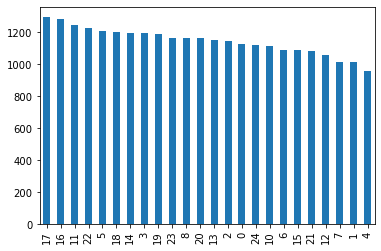

In [173]:
# Analysis
train.label.sort_values().value_counts().plot(kind = 'bar')



In [175]:
print(train['label'].sort_values().unique())

[ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]


In [176]:
#divide data into train and validation
x_train, x_validation, y_train, y_validation = train_test_split(train_data, train_label,test_size=0.2, shuffle= True)

In [182]:
#model

model = tf.keras.models.Sequential([tf.keras.layers.Conv2D(8, (3,3),strides=(1,1),padding='same', activation='relu', input_shape=(28,28,1)),
                                    tf.keras.layers.MaxPooling2D((2,2)),
                                    tf.keras.layers.Conv2D(16, (3,3),strides=(1,1),padding='same', activation='relu'),
                                    tf.keras.layers.Dropout(0.5)
                                    tf.keras.layers.MaxPooling2D((4,4)),
                                    tf.keras.layers.Conv2D(64, (3,3),strides=(1,1),padding='same', activation='relu'),
                                    tf.keras.layers.MaxPooling2D((2,2)),                                    
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(512, activation='relu'),
                                    tf.keras.layers.Dense(26, activation='softmax')
                                   ])

SyntaxError: invalid syntax (<ipython-input-182-f8625d393f12>, line 7)

In [183]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 7, 7, 64)          36928     
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 576)             

In [184]:
# compile model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy',  metrics=['accuracy'])

In [185]:
# data augmentation
train_datagen = ImageDataGenerator(rescale=1./255.,
                                rotation_range=40,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1./255.)

training_gen = train_datagen.flow(x_train, y_train,batch_size=32)
testing_gen = validation_datagen.flow(x_validation, y_validation,batch_size=32)

In [186]:
# train  model
# Train the Model
history = model.fit_generator(
    training_gen,
    epochs=50,
    steps_per_epoch= len(x_train)/32,    
    validation_data=testing_gen,
    validation_steps = len(x_validation)/32
)

Epoch 1/50
687/686 [==============================] - 9s 13ms/step - loss: 1.2890 - accuracy: 0.5834 - val_loss: 0.7718 - val_accuracy: 0.7430
Epoch 2/50
687/686 [==============================] - 9s 13ms/step - loss: 1.2353 - accuracy: 0.5973 - val_loss: 0.6900 - val_accuracy: 0.7849
Epoch 3/50
411/686 [================>.............] - ETA: 3s - loss: 1.2058 - accuracy: 0.6114

KeyboardInterrupt: 

In [ ]:
# Plot the chart for accuracy and loss on both training and validation

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
model.evaluate(test_data, test_label)